In [56]:
#Code written by Akshit Salhotra(23/CS/040)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression as sklearnLinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import copy
import math

### Linear Regression Class Implemented in Numpy

- can optimise parameters using mini-batch gradient descent

- can use the closed from to find the optimal parameters

In [57]:
class LinearRegression:
    
    def __init__(self,numFeatures:int,bias:bool,alpha:float,val_freq:int):
        
        np.random.seed(52)
        self.weights=np.random.randn(1,numFeatures)
        if bias:    
            self.bias=np.random.randn(1,1)
        else:
            self.bias=None
        self.alpha=alpha
        self.val_freq=val_freq
        
    def forward(self,X:np.array):
        
        return np.squeeze((X)@(self.weights.T) +(self.bias if self.bias else 0),axis=-1)
        
    def loss(self,X:np.array,Y:np.array):
        
        preds=self.forward(X)
        return (np.mean((preds-Y)**2)/2).item()
    
    def updateParams(self,X:np.array,Y:np.array):
        
        dw=np.mean( (np.expand_dims(self.forward(X)-Y,axis=-1))*X,axis=0)
        self.weights-=self.alpha*np.expand_dims(dw,axis=0)
        
        if self.bias:
            db=np.mean(self.forward(X)-Y)
            self.bias-=self.alpha*db 
        
    def train(self,epochs:int,batch_size:int,X:np.array,Y:np.array,X_val:np.array,Y_val:np.array):
        self.losses=[]
        self.val_losses=[]
        pbar=tqdm(range(epochs))
        
        for epoch in pbar:
            loss=0
            for i in range(0,X.shape[0],batch_size):

                self.updateParams(X[i:i+batch_size,:],Y[i:i+batch_size])
                loss+=self.loss(X[i:i+batch_size,:],Y[i:i+batch_size])
            
            loss/=math.ceil(X.shape[0]/batch_size)
            self.losses.append(loss)    
            pbar.set_postfix({'loss':loss})

            if (epoch+1) % self.val_freq==0:
                val_loss=self.loss(X_val,Y_val)
                self.val_losses.append(val_loss)
                
        print("training complete!!")
        
        
    def paramsUsingNormalEquation(self,X:np.array,Y:np.array):
        
        if self.bias:
            X=np.concatenate([X,np.expand_dims(np.array(X.shape[0]*[1]),axis=-1)],axis=-1)
        
        params=np.linalg.inv(X.T @ X) @ X.T 
        params=params @ Y
        
        self.weightsNormal=np.expand_dims(params[0:-1],axis=0)
        self.biasNormal=np.expand_dims(params[-1:],axis=0)
        
        
    def forwardNormal(self,X:np.array):

        if self.weightsNormal is not None:
            return np.squeeze((X)@(self.weightsNormal.T) +(self.biasNormal if self.bias else 0),axis=-1)
        else:
            raise NotImplementedError("invalid state as the params have not been estimated using the normal form")
              
        

In [58]:
path_csv="housing.csv"
df=pd.read_csv(path_csv,header=0)

print("number of data points:",len(df))
print(df.head(5))

number of data points: 20640
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [59]:
#dropping rows with nan entries
df.dropna(inplace=True)

### Preprocessing

- dropping nan  values 

- Z-normalisation of features

- Scaling of Y to prevent overflow

In [60]:
unique_ocean_proximity=df['ocean_proximity'].unique()

df['ocean_proximity'] = df['ocean_proximity'].map({v: i for i, v in enumerate(unique_ocean_proximity)})

# data_array=np.transpose(df.to_numpy(),axes=(1,0))
data_array=df.to_numpy()

# X=df[list(range(4))+list(range(5,8))+[9],:]
X=data_array[:,list(range(8))+[9]]

X=(X-np.mean(X,axis=0,keepdims=True))/np.std(X,axis=0,keepdims=True)

Y=data_array[:,8]/(1e+4)

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15,random_state=42,shuffle=True)



In [61]:
val_freq=100
epochs=10000
num_features=9
bias=True
learningRate=0.01
batch=2**14
regressor=LinearRegression(num_features,bias,learningRate,val_freq)

# X=np.random.randn(10,20000)
# Y=np.random.randn(20000)

regressor.train(epochs,batch,X_train,Y_train,X_test,Y_test)
print("final params")
print(regressor.weights,regressor.bias)

100%|██████████| 10000/10000 [01:31<00:00, 109.46it/s, loss=23.4]

training complete!!
final params
[[-8.44162308 -9.07089708  1.14542037 -1.36487497  4.31511165 -4.89539632
   2.20579413  7.52939646 -0.26035014]] [[20.67178745]]


In [62]:
regressor.paramsUsingNormalEquation(X_train,Y_train)
print("params calculated using normal equation:")
print(regressor.weightsNormal,regressor.biasNormal)

params calculated using normal equation:
[[-8.40403762 -8.96653046  1.4281359  -1.80504066  4.83579455 -4.27681345
   1.68388597  7.60862597 -0.23576325]] [[20.67124104]]


### Using the implementation of sklearn

In [63]:
model=sklearnLinearRegression()
sklearnRegressor=model.fit(X_train,Y_train)

print("model params of linear Regression (Sklearn):",sklearnRegressor.coef_,sklearnRegressor.intercept_)

model params of linear Regression (Sklearn): [-8.40403762 -8.96653046  1.4281359  -1.80504066  4.83579455 -4.27681345
  1.68388597  7.60862597 -0.23576325] 20.671241041056486


### Train and val loss curves

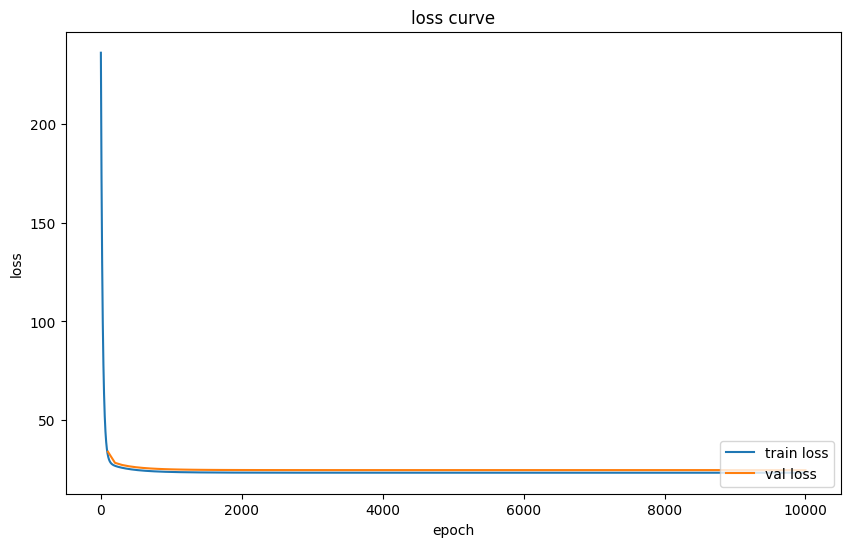

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.plot(regressor.losses,label="train loss")

plt.plot(np.arange(val_freq,epochs+1 if epochs%val_freq==0 else epochs+2,val_freq),regressor.val_losses,label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="lower right")
plt.title("loss curve")

plt.savefig("Images/lossCurves.jpg")

### LOSS SURFACE

- Since, the feature space is 9 dimensional , we will be visualising the loss surface with respect to the top two features(sorted by the magnitude of learned weight) only.

In [66]:
cols=np.argsort(np.abs(regressor.weights),axis=1)[:,:-3:-1].flatten()
rows=np.array([0,0])
print(regressor.weights[rows,cols])
print(regressor.weights)

[-9.07089708 -8.44162308]
[[-8.44162308 -9.07089708  1.14542037 -1.36487497  4.31511165 -4.89539632
   2.20579413  7.52939646 -0.26035014]]


100%|██████████| 300/300 [00:34<00:00,  8.80it/s]


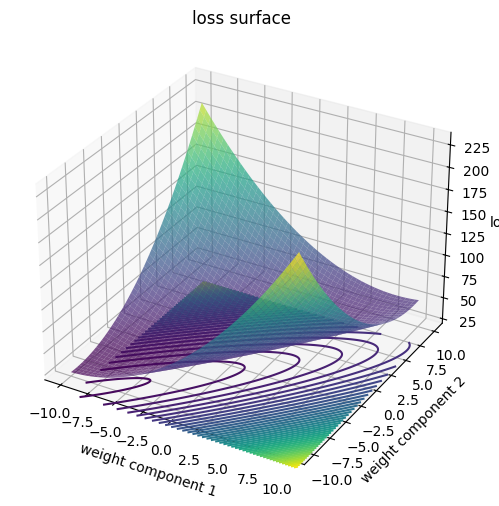

In [67]:
num_points=300

x = np.linspace(-10, 10, num_points)
y = np.linspace(-10, 10, num_points)
X, Y = np.meshgrid(x, y)

copyWeights=copy.copy(regressor.weights)

loss=np.zeros((num_points,num_points))

cols=np.argsort(np.abs(regressor.weights),axis=1)[:,:-3:-1].flatten()
rows=np.array([0,0])

for i in tqdm(range(num_points)):
    for j in range(num_points):
        regressor.weights[rows,cols]=np.array([X[i][j],Y[i][j]])
        loss[i][j]=regressor.loss(X_train,Y_train)
    

regressor.weights=copyWeights

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection="3d")


surf = ax.plot_surface(X, Y, loss, cmap="viridis", alpha=0.7, edgecolor="none")


ax.contour(X, Y, loss, 50, cmap="viridis", offset=-2)  # projected onto z=-2 plane


ax.set_xlabel("weight component 1")
ax.set_ylabel("weight component 2")
ax.set_zlabel("loss")

ax.set_title("loss surface")

# plt.show()
plt.savefig("Images/lossSurface.jpg")

### EVALUATION OF THE MODEL

- MSE

<!-- - RMSE -->

- $R^2$

- MAE

In [68]:
Y_pred_GD=regressor.forward(X_test)
Y_pred_normal=regressor.forwardNormal(X_test)
Y_pred_sklearn=model.predict(X_test)


#MSE
mse_GD = mean_squared_error(Y_test, Y_pred_GD)
mse_normal = mean_squared_error(Y_test, Y_pred_normal)
mse_sklearn = mean_squared_error(Y_test, Y_pred_sklearn)

print("the mse of GD is:",mse_GD)
print("the mse of normal is:",mse_normal)
print("the mse of sklearn is:",mse_sklearn)
print("-------------------------------------------")



#r2 score
r2_GD = r2_score(Y_test, Y_pred_GD)
r2_normal = r2_score(Y_test, Y_pred_normal)
r2_sklearn = r2_score(Y_test, Y_pred_sklearn)

print("the r2 score of GD is:",r2_GD)
print("the r2 score of normal is:",r2_normal)
print("the r2 score of sklearn is:",r2_sklearn)
print("-------------------------------------------")

#MAE
mae_GD = mean_absolute_error(Y_test, Y_pred_GD)
mae_normal = mean_absolute_error(Y_test, Y_pred_normal)
mae_sklearn = mean_absolute_error(Y_test, Y_pred_sklearn)

print("the mae of GD is:",mae_GD)
print("the mae of normal is:",mae_normal)
print("the mae of sklearn is:",mae_sklearn)
print("-------------------------------------------")


the mse of GD is: 49.52551474267718
the mse of normal is: 49.5548340518484
the mse of sklearn is: 49.5548340518484
-------------------------------------------
the r2 score of GD is: 0.6366230457879198
the r2 score of normal is: 0.63640792513099
the r2 score of sklearn is: 0.63640792513099
-------------------------------------------
the mae of GD is: 5.159463115086861
the mae of normal is: 5.167378016409239
the mae of sklearn is: 5.167378016409242
-------------------------------------------
